## Data Exploration (ML50-2023)

### __Importing libraries__

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

# -------------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### __Importing data__

In [208]:
# Data path : ../Data/test.csv
test_path = os.path.join('..', 'Data', 'test.csv')
train_path = os.path.join('..', 'Data', 'train.csv')
icd_9_path = os.path.join('..', 'Data', 'icd9_codes.txt')

# Read data
test = pd.read_csv(test_path, index_col='encounter_id')
train = pd.read_csv(train_path, index_col='encounter_id')

# Read ICD-9 codes
icd_9 = pd.read_csv(icd_9_path, sep=',', encoding='ISO-8859-1', index_col=0)
icd_9['3 digit code'] = icd_9.index.str[:3]
icd_9.set_index('3 digit code', inplace=True)
icd_9 = icd_9[~icd_9.index.duplicated(keep='first')]

# Keep track of the ids of the test and training data
test_ids = test.index
train_ids = train.index

# Data will have to be treated as a whole, so we will concatenate the test and training data
data = pd.concat([train, test], axis=0)

### __Minor changes to the data__
- __Remove 0 variance columns__
- __Changing column names__
- __Binary encoding__
- __?, Not Mapped, Not Available as NaN__
- __Applying the changes to the test and train data__

__1. Removing 0 variance columns__

In [209]:
data = data.drop(['country'], axis=1)

__2. Changing column names__

In [210]:
mapper = {
    'outpatient_visits_in_previous_year': 'n_outvis',
    'inpatient_visits_in_previous_year': 'n_invis',
    'emergency_visits_in_previous_year': 'n_emvis',
    'change_in_meds_during_hospitalization': 'b_changeMeds',
    'prescribed_diabetes_meds': 'b_diabetesMeds',
    'length_of_stay_in_hospital': 'n_stay',
    'number_of_medications': 'n_meds',
    'primary_diagnosis': 'c_diag1',
    'secondary_diagnosis': 'c_diag2',
    'additional_diagnosis': 'c_diag3',
    'number_diagnoses': 'n_diag',
    'number_lab_tests': 'n_tests',
    'discharge_disposition': 'c_disp',
    'race' : 'c_race',
    'gender' : 'b_gender',
    'age' : 'c_age',
    'weight' : 'c_weight',
    'admission_type' : 'c_admission',
    'payer_code' : 'c_payer',
    'medical_specialty' : 'c_specialty',
    'glucose_test_result' : 'c_glu',
    'a1c_test_result' : 'c_a1c',
    'average_pulse_bpm' : 'n_pulse',
    'readmitted_binary' : 'b_target',
    'readmitted_multiclass' : 'c_target',
    'medication' : 'c_medication',
    'admission_source' : 'c_source',
    'non_lab_procedures' : 'n_nonLab',
    'patient_id' : 'c_patient',
}

data = data.rename(columns=mapper)
data.columns

Index(['c_patient', 'c_race', 'b_gender', 'c_age', 'c_weight', 'c_payer',
       'n_outvis', 'n_emvis', 'n_invis', 'c_admission', 'c_specialty',
       'n_pulse', 'c_disp', 'c_source', 'n_stay', 'n_tests', 'n_nonLab',
       'n_meds', 'c_diag1', 'c_diag2', 'c_diag3', 'n_diag', 'c_glu', 'c_a1c',
       'b_changeMeds', 'b_diabetesMeds', 'c_medication', 'b_target',
       'c_target'],
      dtype='object')

__3. Binary encoding__

In [211]:
binary_features = [col for col in data.columns if col.startswith('b_')]
data['b_gender'] = data['b_gender'].map({'Female' : 0, 'Male' : 1})
data['b_changeMeds'] = data['b_changeMeds'].map({'No' : 0, 'Ch' : 1})
data['b_diabetesMeds'] = data['b_diabetesMeds'].map({'No' : 0, 'Yes' : 1})
data['b_target'] = data['b_target'].map({'No' : 0, 'Yes' : 1})

data[binary_features]

,b_gender,b_changeMeds,b_diabetesMeds,b_target
encounter_id,,,,
533253,0.0,0,0,0.0
426224,1.0,0,1,0.0
634063,0.0,1,1,0.0
890610,1.0,0,0,0.0
654194,0.0,0,0,0.0
...,...,...,...,...
451150,1.0,0,0,NaN
549298,1.0,0,1,NaN
327586,0.0,0,1,NaN


__4. ?, Not Mapped, Not Available as NaN__

In [212]:
to_replace = ['?', 'Not Mapped', 'Not Available', ' Not Mapped']
data = data.replace(to_replace, np.nan)

__5. Applying the changes to the test and train data__

In [213]:
train = data.loc[train_ids]
test = data.loc[test_ids]

### __Changes in data__

In [314]:
from IPython.display import display, HTML

def var_report(column_name, data=data, train_ids=train_ids, test_ids=test_ids):
    # If some of the train_ids are not in the data, dont get an error
    train_ids = [idx for idx in train_ids if idx in data.index]
    test_ids = [idx for idx in test_ids if idx in data.index]
    train = data.loc[train_ids]
    test = data.loc[test_ids]
    
    train_counts = train[column_name].value_counts(dropna=False)
    test_counts = test[column_name].value_counts(dropna=False)
    train_counts_pct = round(100*train_counts / len(train[column_name]), 2)
    test_counts_pct = round(100*test_counts / len(test[column_name]), 2)

    # Append percentages to the test counts
    test_counts = pd.concat([test_counts, test_counts_pct], axis=1)

    # For train, add the correlation with the target
    group = round(train.groupby(column_name, dropna=False)['b_target'].mean(),3)
    train_counts = pd.merge(train_counts, group, left_index=True, right_index=True)
    train_counts = pd.merge(train_counts, train_counts_pct, left_index=True, right_index=True)

    # Rename columns
    train_counts.columns = ['count', 'target_mean', 'percentage']
    test_counts.columns = ['count', 'percentage']

    # Adding the distance in percentage to the weighted mean
    weighted_mean = np.dot(train_counts['target_mean'], train_counts['count']) / train_counts['count'].sum()
    train_counts['distance (%)'] = round(100*((train_counts['target_mean'] - weighted_mean) / weighted_mean),2)

    # Convert to html
    train_counts_html = train_counts.to_html()
    test_counts_html = test_counts.to_html()

    # Calculate missing values and their percentage
    train_missing = train[column_name].isna().sum()
    test_missing = test[column_name].isna().sum()
    train_missing_pct = round(100*train_missing/len(train[column_name]), 2)
    test_missing_pct = round(100*test_missing/len(test[column_name]), 2)

    # Format the missing values and their percentage as strings
    train_missing_str = "{} ({:.2f}%)".format(train_missing, train_missing_pct)
    test_missing_str = "{} ({:.2f}%)".format(test_missing, test_missing_pct)

    # Create a histplot for the column with the target as hue
    fig, axis = plt.subplots(1, 2, figsize=(15, 5))
    train_counts_ordered = train_counts.sort_values(by='target_mean', ascending=False)
    train_counts_ordered.index = train_counts_ordered.index.astype(str)
    sns.barplot(x=train_counts_ordered.index, data=train_counts_ordered, y='distance (%)', ax=axis[0])
    sns.barplot(x=train_counts_ordered.index, data=train_counts_ordered, y='count', ax=axis[1])

    # Rotate the xticks
    axis[0].tick_params(axis='x', rotation=90)
    axis[1].tick_params(axis='x', rotation=90)

    # If there are more than 25 categories, dont show the labels
    if len(train_counts) > 20:
        axis[0].tick_params(axis='x', labelsize=0)
        axis[1].tick_params(axis='x', labelsize=0)
    # Set the title
    axis[0].set_title('Proportion of target in {}'.format(column_name))
    axis[1].set_title('Distribution of {}'.format(column_name))

    display(HTML(f"""
        <div style="display: flex; justify-content: space-between;">
            <div style="padding-right: 1px;">
                <h3>Value counts in train data:</h3>
                {train_counts_html}
            </div>
            <div>
                <h3>Value counts in test data:</h3>
                {test_counts_html}
            </div>
            <div>
                <h3>Missing values in train data:</h3>
                {train_missing_str}
                <h3>Missing values in test data:</h3>
                {test_missing_str}
            </div>
        </div>
    """))

# One hot encoding, avoid dummy trap
def one_hot_encode(data, column_name, drop_first=True):
    dummies = pd.get_dummies(data[column_name], prefix=column_name, drop_first=drop_first, dummy_na=True, dtype=np.int8)
    # Change the names of the dummies so that they start with b_ instead of c_
    dummies.columns = ['b_' + col[2:] for col in dummies.columns]
    data = pd.concat([data, dummies], axis=1)
    data = data.drop(column_name, axis=1)
    return data

#### __1. Race__
__Modifications:__
- One hot encoding without dropping the NaN values (7.5%)
<br>

__Relevant Information:__
- 5 categories + NaN
- Other shows relevant counter information whilst caucasian has the highest amount of people with some positive information

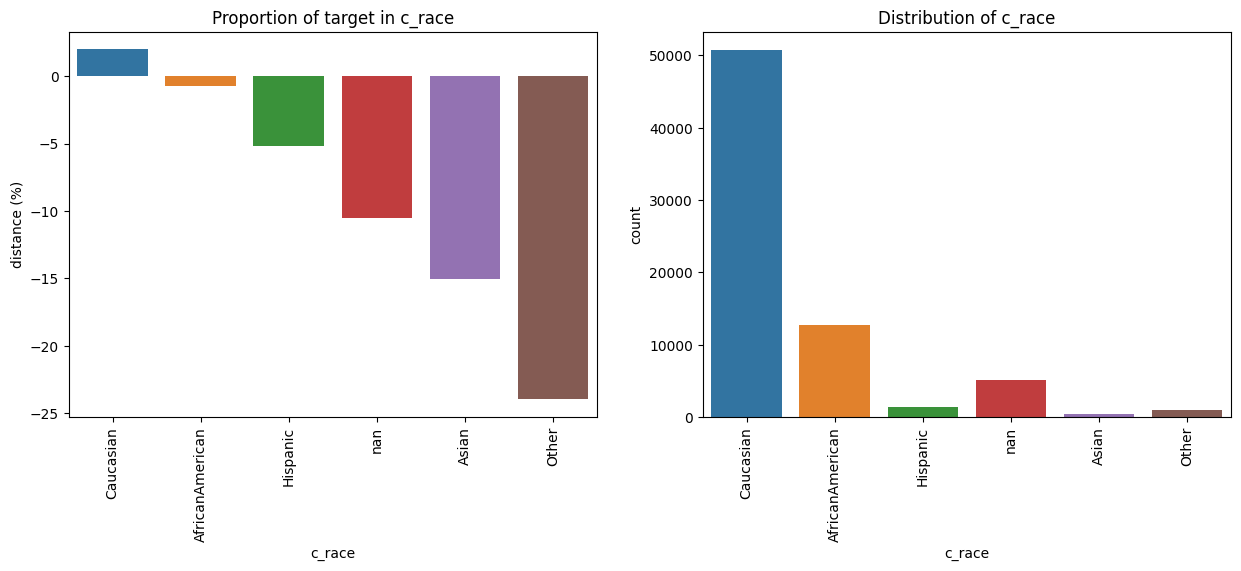

In [215]:
var_report('c_race', data)

Encoding race with one hot encoding

In [216]:
data = one_hot_encode(data, 'c_race')

#### __2. Gender__
__Modifications:__
- Droping the NaN values (<0.01%)
<br>

__Relevant Information:__
- Doesn't show relevant information

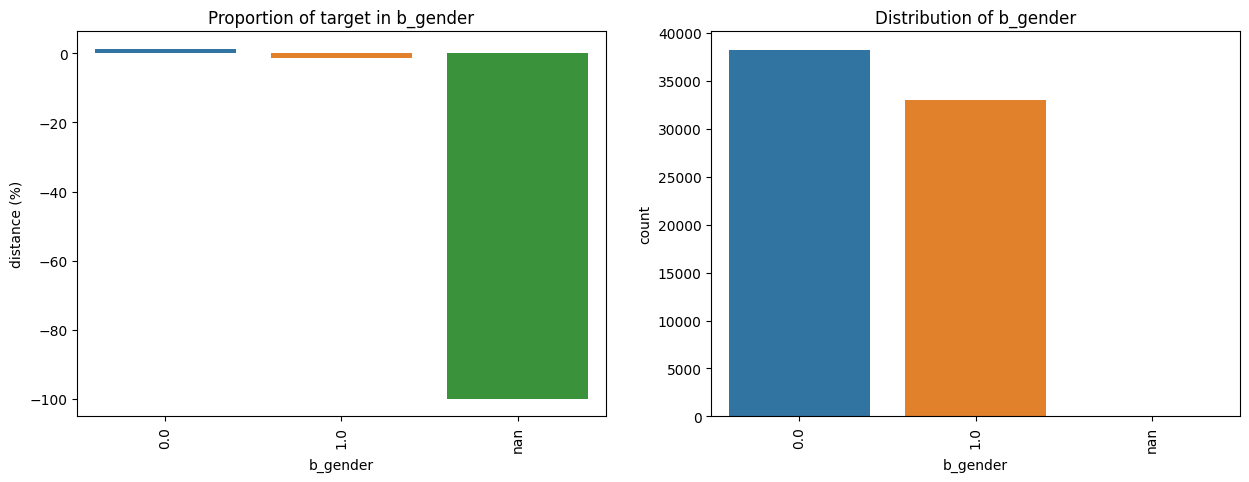

In [217]:
var_report('b_gender', data)

In [218]:
# Drop variables in train with a Nan gender
ids_to_drop = data[data.isna()['b_gender']].index
train = train.drop(ids_to_drop)
data = data[~data.isna()['b_gender']]

#### __3. Age__
__Modifications:__
- Considering the middle point of the age range
<br>

__Relevant Information:__
- Significant information for the model, especially for the age range 70-80 and 80-90, with a higher percentage of people readmitted and a large count of people in those age ranges

,count,target_mean,percentage,distance (%)
c_age,,,,
[70-80),17357,0.118,24.37,5.56
[60-70),14907,0.109,20.93,-2.49
[80-90),11510,0.123,16.16,10.04
[50-60),11423,0.099,16.04,-11.44
[40-50),6418,0.105,9.01,-6.07
NaN,3557,0.110,4.99,-1.59
[30-40),2536,0.109,3.56,-2.49
[90-100),1875,0.117,2.63,4.67
[20-30),1071,0.142,1.50,27.03


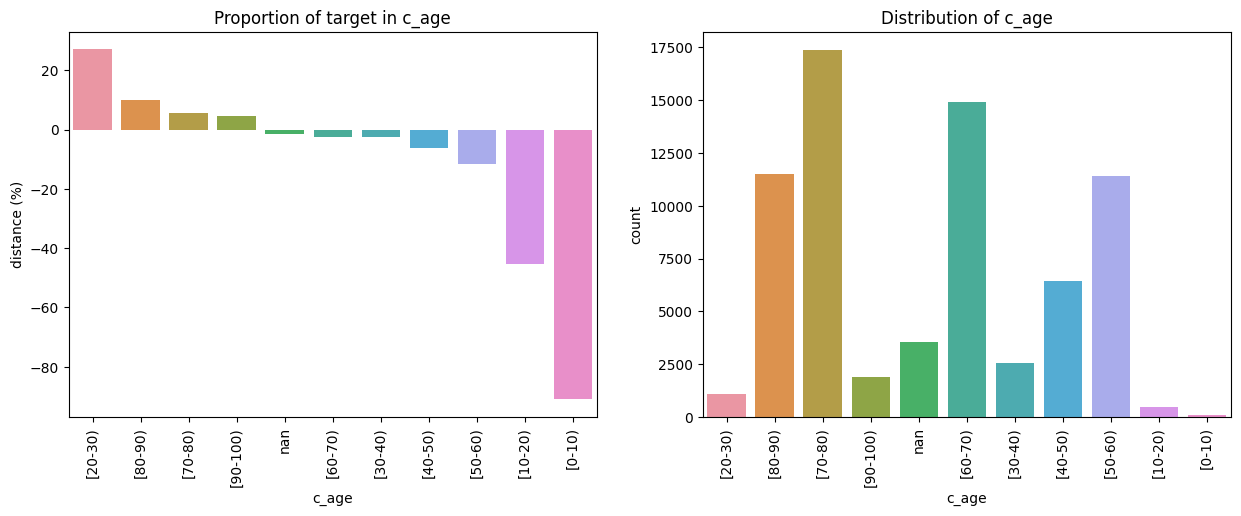

In [219]:
var_report('c_age', data)

In [220]:
age_dict = {'[0-10)': 5,
           '[10-20)': 15,
           '[20-30)': 25,
           '[30-40)': 35,
           '[40-50)': 45,
           '[50-60)': 55,
           '[60-70)': 65,
           '[70-80)': 75,
           '[80-90)': 85,
           '[90-100)': 95}

data['c_age'] = data['c_age'].map(age_dict)

#### __4. Weight__
__Modifications:__
- Droping the column
- Creating a new column with the information if the patient was weighted or not
<br>

__Relevant Information:__
- Very little relevant information, with a large amount of missing values. 

,count,target_mean,percentage,distance (%)
c_weight,,,,
NaN,68987,0.112,96.85,0.10
[75-100),933,0.109,1.31,-2.58
[50-75),636,0.112,0.89,0.10
[100-125),449,0.111,0.63,-0.80
[125-150),96,0.052,0.13,-53.53
[25-50),67,0.104,0.09,-7.05
[0-25),35,0.171,0.05,52.83
[150-175),21,0.095,0.03,-15.10
[175-200),7,0.143,0.01,27.80


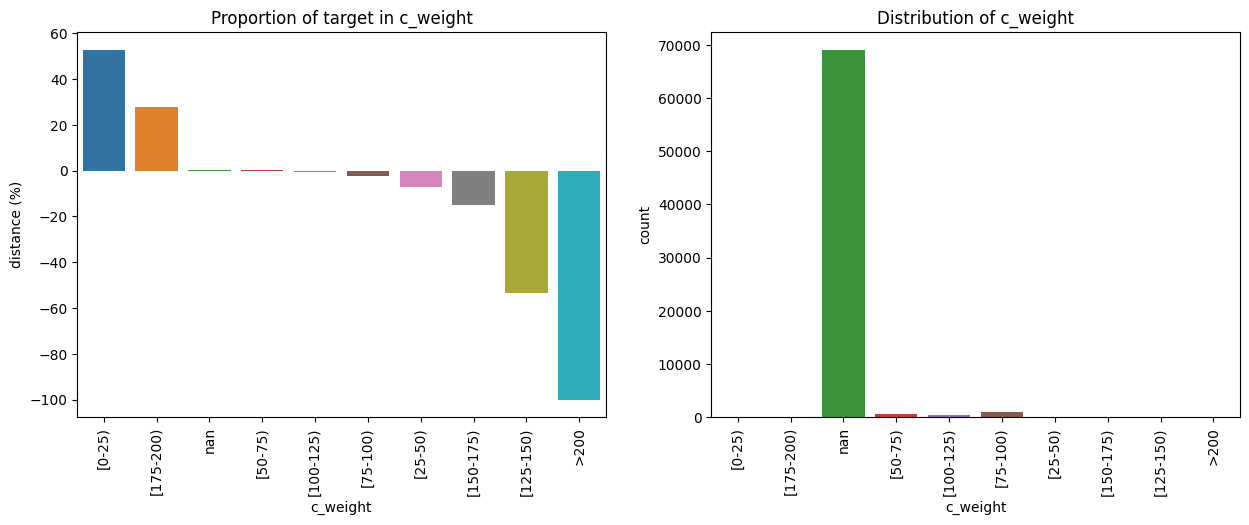

In [221]:
var_report('c_weight', data)

In [222]:
data['b_weight'] = data['c_weight'].notna().astype(np.int8)
data = data.drop('c_weight', axis=1)
print(data['b_weight'].value_counts(dropna=False))

b_weight
0    98566
1     3197
Name: count, dtype: int64


#### __5. Payer code__
__Modifications:__
- Creating a new c_payer column - $payerGroup$ - that is dimensionally reduced
- One hot encoding
<br>

__Relevant Information:__
- Lots of relevant information for the model. Altough there are a lot of missing values, missing values here probably indicate that the patient doesn't have an insurance plan, which is relevant information for the model


,count,target_mean,percentage,distance (%)
c_payer,,,,
NaN,28200,0.115,39.59,3.07
MC,22683,0.119,31.84,6.66
HM,4319,0.098,6.06,-12.16
SP,3541,0.101,4.97,-9.48
BC,3292,0.094,4.62,-15.75
MD,2484,0.125,3.49,12.04
CP,1760,0.090,2.47,-19.33
UN,1733,0.086,2.43,-22.92
CM,1347,0.088,1.89,-21.13


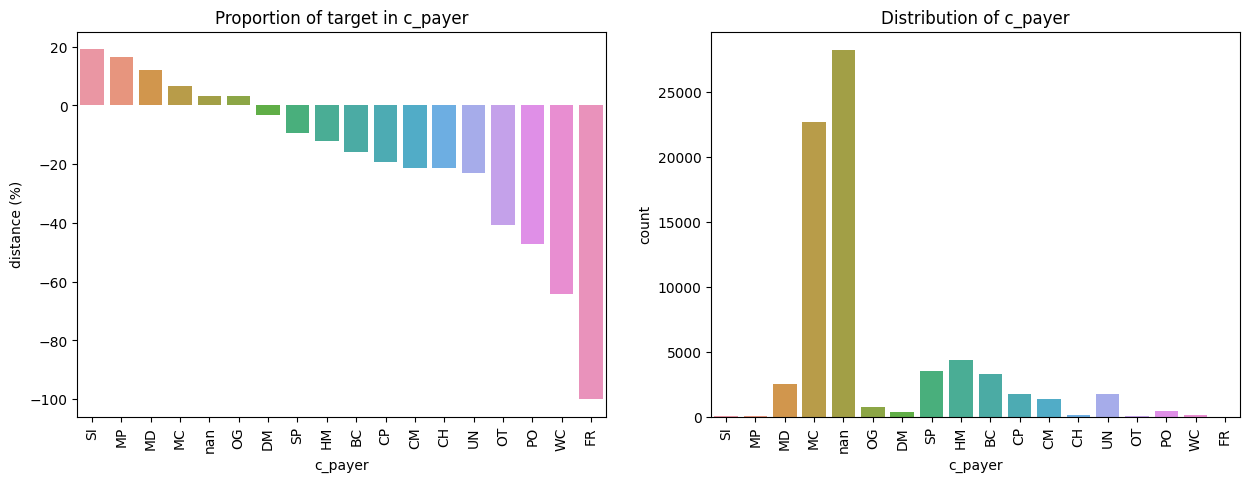

In [223]:
var_report('c_payer', data)

Creating payerGroup column

In [224]:
data['c_payerGroup'] = data['c_payer'].map({
    'SI' : 'High',
    'MP' : 'High',
    'MD' : 'High',
    'MC' : 'High',
    'OG' : 'High',
    'DM' : 'Medium',
    'SP' : 'Medium',
    'HM' : 'Low',
    'BC' : 'Low',
    'CP' : 'Low',
    'UN' : 'Low',
    'CM' : 'Low',
    'PO' : 'Low',
    'CH' : 'Low',
    'WC' : 'Low',
    'OT' : 'Low',
    'FR' : 'Low',
}, na_action='ignore').fillna('Medium')

In [225]:
# One hot encode the payer group
data = one_hot_encode(data, 'c_payerGroup')
data = one_hot_encode(data, 'c_payer')

#### __6. Out-/Em-/Invisits__
__Modifications:__
- Croping the outliers and grouping them in a specific bin (4,5,3), changing the threshold based on the variable in question
- Creating a n_visits column with the sum of the 3 variables, and n_visits_pure with the sum of the unclipped variables (last bin = 9). They have a sligthly different distribution, so we will keep both. Why did we clip at 9? So that we keep a linear relationship between the number of visits and the readmission rate mean (see plot below 6.4)
<br>

__Relevant Information:__
- It seems like this variable has relevant information for the model, with a higher percentage of people readmitted in the higher bins. 
- Unsatisfactory high amount of 0s, which can be changed by summing the 3 variables

##### __6.0 Pure visits__
__Last bin = 9__

,count,target_mean,percentage,distance (%)
n_purevis,,,,
0,38986,0.081,54.73,-27.32
1,14031,0.114,19.70,2.28
2,7072,0.149,9.93,33.69
3,4109,0.156,5.77,39.97
4,2490,0.174,3.50,56.12
5,1418,0.179,1.99,60.60
6,920,0.228,1.29,104.57
7,629,0.237,0.88,112.64
8,397,0.252,0.56,126.10


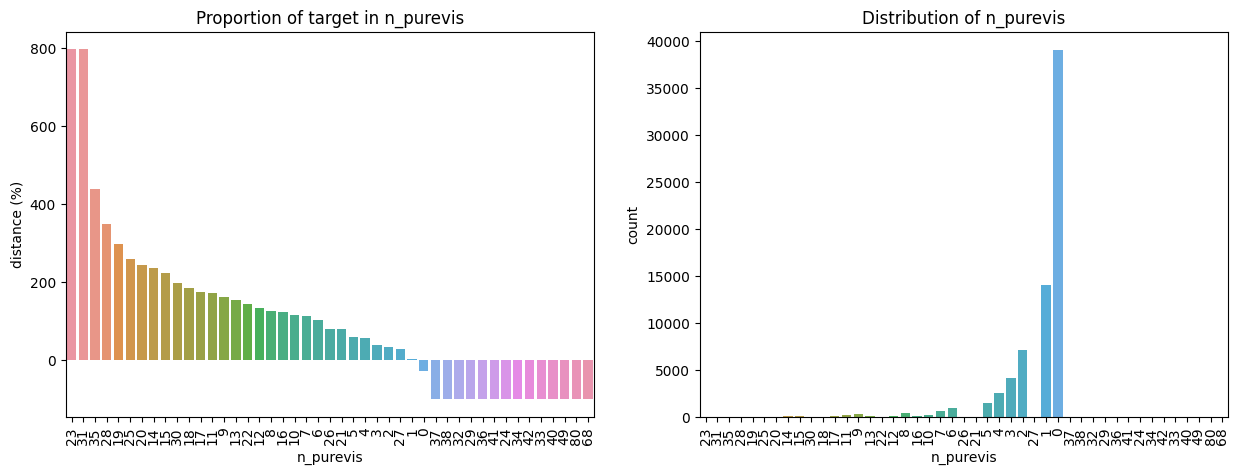

In [226]:
data['n_purevis'] = data['n_outvis'] + data['n_invis'] + data['n_emvis']
var_report('n_purevis', data)

In [227]:
data['n_purevis'] = data['n_purevis'].clip(upper=9)
data.value_counts('n_purevis')

n_purevis
0    55825
1    19941
2    10062
3     5904
4     3570
5     2036
9     1690
6     1313
7      868
8      554
Name: count, dtype: int64

##### __6.1 Outvisits__
__Last bin = 4__

,count,target_mean,percentage,distance (%)
n_outvis,,,,
0,59584,0.106,83.65,-4.67
1,5967,0.142,8.38,27.71
2,2465,0.138,3.46,24.11
3,1431,0.125,2.01,12.42
4,760,0.154,1.07,38.50
5,370,0.111,0.52,-0.17
6,212,0.104,0.30,-6.47
7,107,0.168,0.15,51.09
8,67,0.030,0.09,-73.02


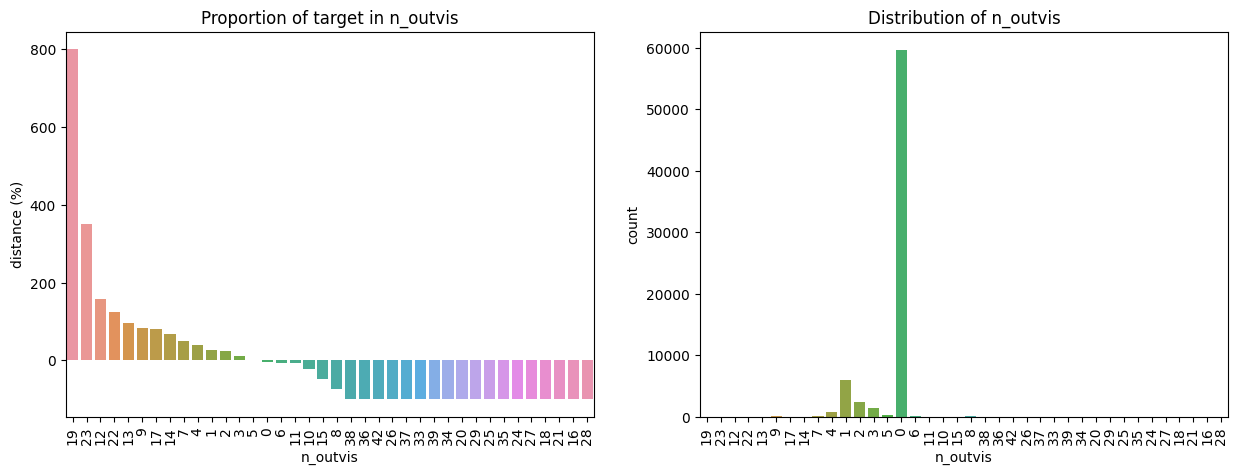

In [228]:
var_report('n_outvis', data)

In [229]:
# Values in n_outvis above 4 will be set to 4
data['n_outvis'] = data['n_outvis'].clip(upper=4)
data['n_outvis'].value_counts(dropna=False)

n_outvis
0    85024
1     8547
2     3594
4     2556
3     2042
Name: count, dtype: int64

##### __6.2 Invisits__
- __Last bin = 5__

,count,target_mean,percentage,distance (%)
n_invis,,,,
0,47228,0.084,66.30,-24.72
1,13706,0.128,19.24,14.71
2,5303,0.175,7.44,56.82
3,2407,0.210,3.38,88.19
4,1159,0.240,1.63,115.07
5,553,0.300,0.78,168.84
6,361,0.357,0.51,219.92
7,195,0.364,0.27,226.20
8,109,0.486,0.15,335.52


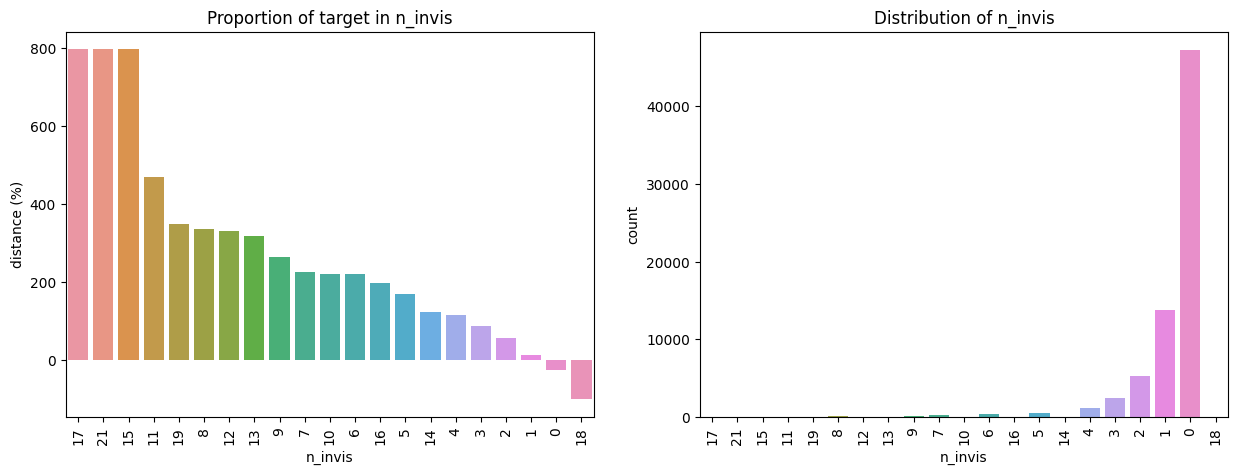

In [230]:
var_report('n_invis', data)

In [231]:
data['n_invis'] = data['n_invis'].clip(upper=5)
data['n_invis'].value_counts(dropna=False)

n_invis
0    67627
1    19521
2     7566
3     3411
5     2016
4     1622
Name: count, dtype: int64

##### __6.3 Emvisits__
- __Last bin = 3__

,count,target_mean,percentage,distance (%)
n_emvis,,,,
0,63239,0.105,88.78,-6.03
1,5422,0.142,7.61,27.08
2,1432,0.187,2.01,67.35
3,502,0.193,0.70,72.72
4,262,0.324,0.37,189.96
5,126,0.238,0.18,113.00
6,71,0.225,0.10,101.36
7,47,0.234,0.07,109.42
10,24,0.375,0.03,235.60


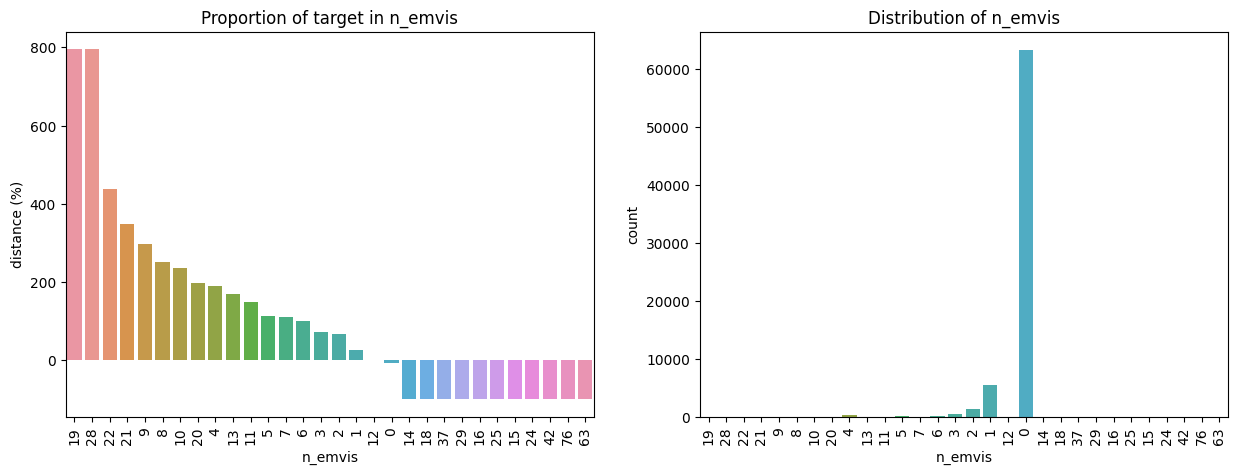

In [232]:
var_report('n_emvis', data)

In [233]:
data['n_emvis'] = data['n_emvis'].clip(upper=3)
data['n_emvis'].value_counts(dropna=False)

n_emvis
0    90380
1     7677
2     2042
3     1664
Name: count, dtype: int64

##### __6.4 Total visits__
- __Last bin = 9__

,count,target_mean,percentage,distance (%)
n_vis,,,,
0,38986,0.081,54.73,-27.31
1,14031,0.114,19.70,2.31
2,7072,0.149,9.93,33.72
3,4168,0.155,5.85,39.11
4,2905,0.165,4.08,48.08
5,1833,0.207,2.57,85.77
6,981,0.250,1.38,124.37
7,561,0.257,0.79,130.65
8,393,0.305,0.55,173.73


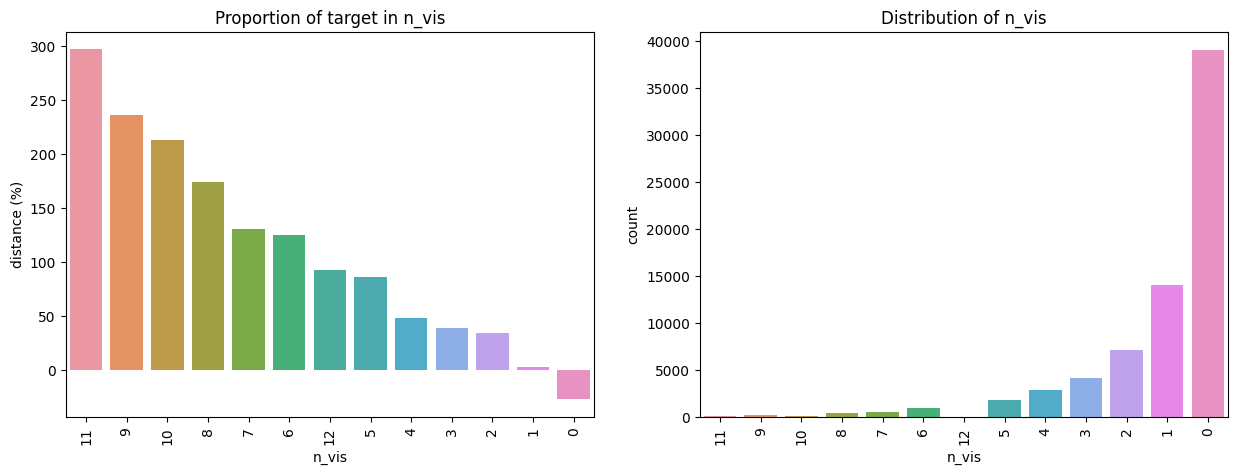

In [234]:
data['n_vis'] = data['n_outvis'] + data['n_invis'] + data['n_emvis']
var_report('n_vis', data)

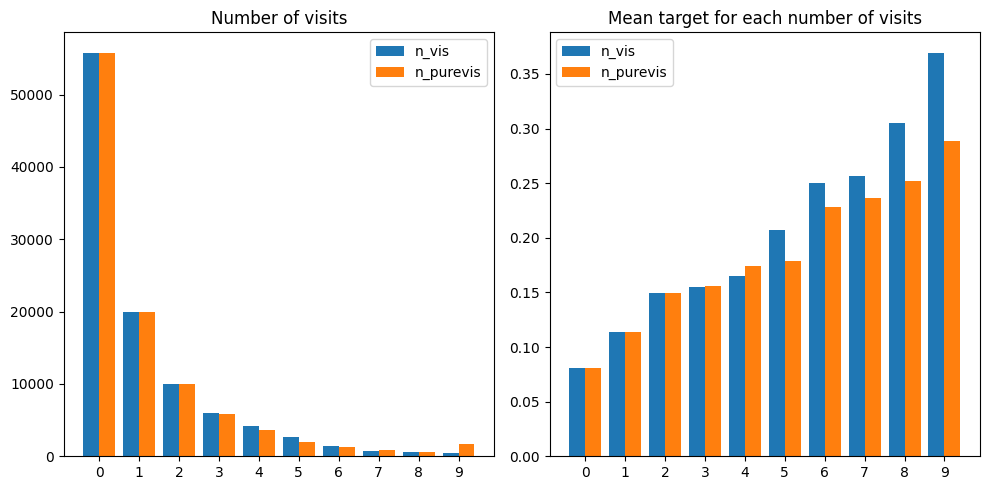

In [235]:
data['n_vis'] = data['n_vis'].clip(upper=9)
tab_vis = data['n_vis'].value_counts(dropna=False)
tab_vis = pd.concat([tab_vis, data['n_purevis'].value_counts(dropna=False)], axis=1)
tab_vis.columns = ['n_vis', 'n_purevis']

# Plot the distribution of the number of visits on the same graph
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
width = 0.4
ax[0].bar(tab_vis.index, tab_vis['n_vis'], width=width, label='n_vis')
ax[0].bar(tab_vis.index+width, tab_vis['n_purevis'], width=width, label='n_purevis')
ax[0].set_title('Number of visits')
ax[0].set_xticks(tab_vis.index + width / 2)
ax[0].set_xticklabels(tab_vis.index)
# Set the legend
ax[0].legend()

# Plot the mean target for each number of visits
ax[1].bar(tab_vis.index, data.groupby('n_vis')['b_target'].mean(), width=width, label='n_vis')
ax[1].bar(tab_vis.index+width, data.groupby('n_purevis')['b_target'].mean(), width=width, label='n_purevis')
ax[1].set_title('Mean target for each number of visits')
ax[1].set_xticks(tab_vis.index + width / 2)
ax[1].set_xticklabels(tab_vis.index)
# Set the legend
ax[1].legend()

plt.tight_layout()
plt.show()


#### __7. Admission Type__
__Modifications:__
- One hot encoding
<br>

__Relevant Information:__
- Emergency admissions have a higher percentage of people readmitted, which is relevant information for the model. Urgent as well, but much less than emergency

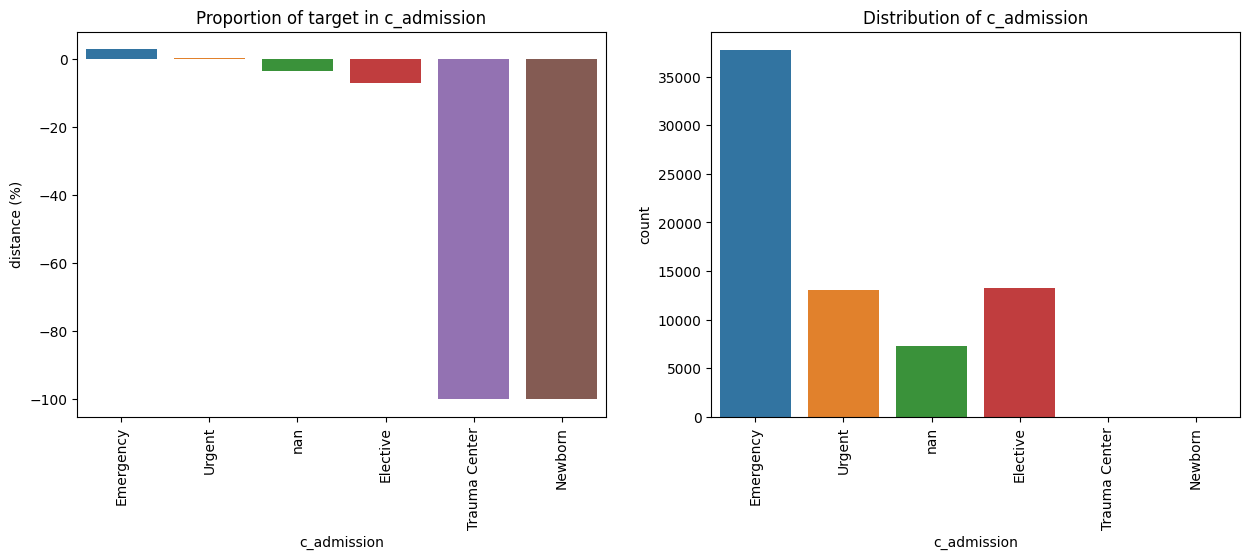

In [240]:
var_report('c_admission', data)

In [247]:
# Group Trauma Center and Newborn into Other
data['c_admission'] = data['c_admission'].replace({'Trauma Center' : 'Other', 'Newborn' : 'Other'})
data = one_hot_encode(data, 'c_admission', drop_first=False).drop('b_admission_Other', axis=1)

#### __8. Medical Specialty__
__Modifications:__
- Creating 8 groups based on the target mean
- One hot encoding the groups 
<br>

__Relevant Information:__
- Some relevant information for the model, with a higher percentage of people readmitted in some groups with high counts

,count,target_mean,percentage,distance (%)
c_specialty,,,,
NaN,34920,0.116,49.02,3.84
InternalMedicine,10292,0.112,14.45,0.26
Emergency/Trauma,5319,0.113,7.47,1.16
Family/GeneralPractice,5217,0.117,7.32,4.74
Cardiology,3715,0.079,5.22,-29.28
Surgery-General,2144,0.115,3.01,2.95
Nephrology,1136,0.157,1.59,40.54
Orthopedics,954,0.101,1.34,-9.59
Orthopedics-Reconstructive,867,0.080,1.22,-28.39


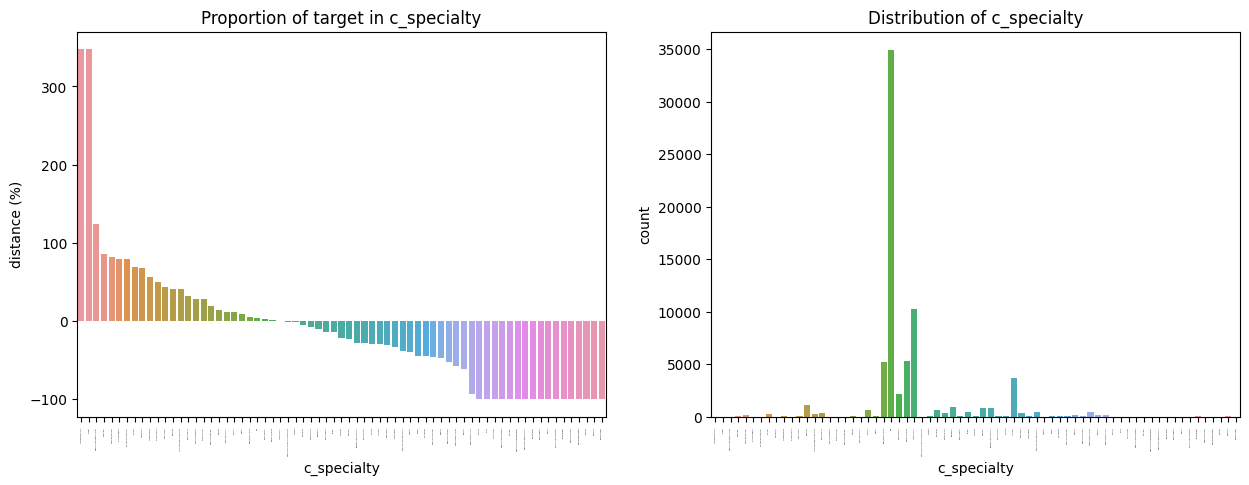

In [251]:
var_report('c_specialty', data)

In [278]:
group = data.groupby('c_specialty', dropna=False)['b_target'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)
# Only print the specialties with more than 1000 observations
group_ = group[group['count'] > 500]
group_

,mean,std,count
c_specialty,,,
Nephrology,0.156690,0.363668,1136
Psychiatry,0.125418,0.331470,598
Family/GeneralPractice,0.117117,0.321591,5217
NaN,0.115865,0.320067,34920
Surgery-General,0.114739,0.318781,2144
Emergency/Trauma,0.113179,0.316841,5319
InternalMedicine,0.111543,0.314819,10292
Pulmonology,0.106383,0.308580,611
Orthopedics,0.100629,0.300995,954


In [293]:
# Lets now group the specialties into groups
group_1 = group[group['mean'] > 0.147].index
group_2 = group[(group['mean'] <= 0.147) & (group['mean'] > 0.117)].index
group_3 = group[(group['mean'] <= 0.117) & (group['mean'] > 0.1148)].index
group_4 = group[(group['mean'] <= 0.1148) & (group['mean'] > 0.113)].index
group_5 = group[(group['mean'] <= 0.113) & (group['mean'] > 0.111)].index
group_6 = group[(group['mean'] <= 0.111) & (group['mean'] > 0.09)].index
group_7 = group[(group['mean'] <= 0.09) & (group['mean'] > 0.07)].index
group_8 = group[(group['mean'] <= 0.07)].index

# Group the specialties
for i in range(1, 9):
    data['b_specialty_group_{}'.format(i)] = data['c_specialty'].isin(locals()['group_{}'.format(i)]).astype(np.int8)

data = data.drop('c_specialty', axis=1)

#### __9. Pulse (BPM)__
__Modifications:__
- Deleting the pulse column
<br>

__Relevant Information:__
- No relevant information 

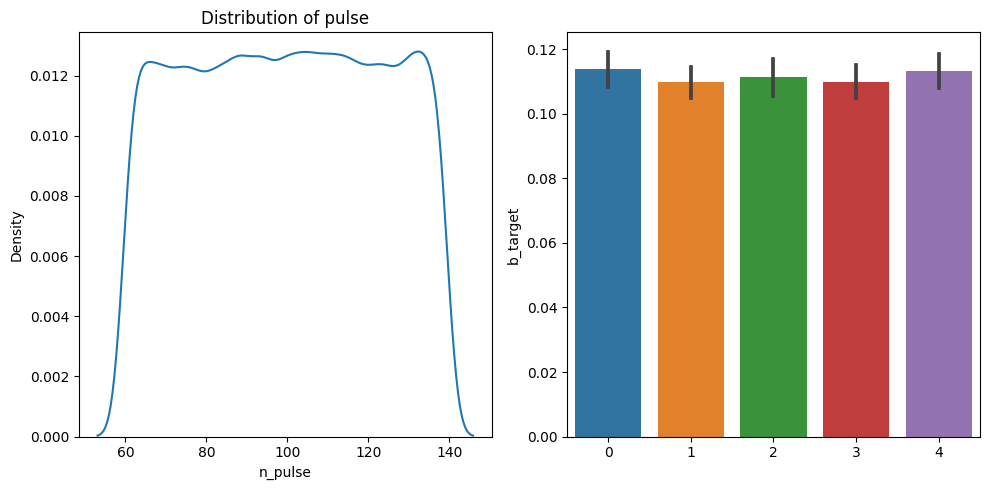

In [304]:
# Plot the pulse distribution
fig, ax = plt.subplots(figsize=(10, 5), ncols=2, nrows=1)
# KDE plot
sns.kdeplot(data['n_pulse'], ax=ax[0])
# Target mean by pulse
group = data.groupby('n_pulse')['b_target'].mean()
# Cut the pulse into 10 bins
group = pd.cut(group.index, bins=5, labels=range(5))
# Plot the mean target by pulse
sns.barplot(x=group, y=data.groupby('n_pulse')['b_target'].mean(), ax=ax[1])
ax[0].set_title('Distribution of pulse')
plt.tight_layout()
plt.show()

In [305]:
data = data.drop('n_pulse', axis=1)

#### __10. Disposition__
__Modifications:__
- Grouping the categories with low counts in a new category (by the target mean), and one hot encoding
<br>

__Relevant Information:__
- A lot of relevant information for the model, with a higher percentage of people readmitted in some categories

,count,target_mean,percentage,distance (%)
c_disp,,,,
Discharged to home,42254,0.093,59.32,-16.70
Discharged/transferred to SNF,9780,0.146,13.73,30.77
Discharged/transferred to home with home health service,9005,0.126,12.64,12.85
NaN,3269,0.121,4.59,8.38
Discharged/transferred to another short term hospital,1488,0.165,2.09,47.79
Discharged/transferred to another rehab fac including rehab units of a hospital .,1392,0.279,1.95,149.89
Expired,1135,0.000,1.59,-100.00
Discharged/transferred to another type of inpatient care institution,822,0.209,1.15,87.20
Discharged/transferred to ICF,571,0.124,0.80,11.06


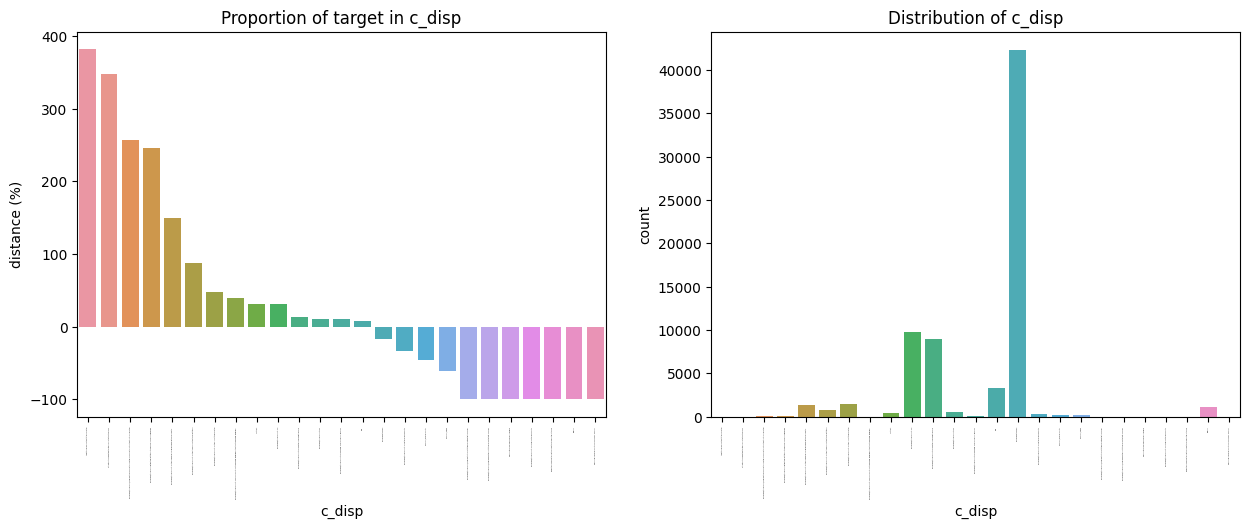

In [315]:
var_report('c_disp', data)

In [318]:
# Lets group the discharge dispositions into groups
group = data.groupby('c_disp', dropna=False)['b_target'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)
group_ = group[group['count'] > 200]
group_


,mean,std,count
c_disp,,,
Discharged/transferred to another rehab fac including rehab units of a hospital .,0.278736,0.448538,1392
Discharged/transferred to another type of inpatient care institution,0.209246,0.407018,822
Discharged/transferred to another short term hospital,0.165323,0.371596,1488
Left AMA,0.147268,0.354795,421
Discharged/transferred to SNF,0.146217,0.353341,9780
Discharged/transferred to home with home health service,0.126374,0.332289,9005
Discharged/transferred to ICF,0.124343,0.330262,571
NaN,0.121444,0.326692,3269
Discharged to home,0.092749,0.290083,42254


In [345]:
def map_to_label(value):
   if value > 0.25:
       return 'rehab'
   elif value <= 0.25 and value > 0.2:
       return 'transCare'
   elif value <= 0.2 and value > 0.15:
       return 'transHosp'
   elif value <= 0.15 and value > 0.14:
       return 'disSNF'
   elif value <= 0.14 and value > 0.124:
       return 'disHHS'
   elif value <= 0.124 and value > 0.12:
       return 'disNone'
   elif value <= 0.12 and value > 0.09:
       return 'disHome'
   elif value <= 0.09 and value > 0.02:
       return 'disHospice'
   else:
       return 'disExpired'
   
data['c_disp'] = data['c_disp'].map(group['mean'].apply(map_to_label))

In [352]:
data = one_hot_encode(data, 'c_disp', drop_first=False)

#### __11. Admission Source__
__Modifications:__
<br>

__Relevant Information:__